## On the use of a predictive model on hotel cancellations
***
> The data for this experiment was kindly provided by [DHAUZ Analytics](https://dhauz.com/)

This notebook contains the process of data analysis and creation of a classification algorithm to tackle the task of predicting hotel cancellations. An initial analysis is conducted on the dataset, which aims to explore the kind of data we've been provided; said analysis is refined by the use of inferential statistics (e.g., hypothesis testing) to draw conclusions from the information that's been gathered. Finally, an appropriate machine learning model is applied to solve the task.


### 1. Downloading the dataset
***
The first step consists of downloading the dataset. Given it's in a RAR file, Python's ``zipfile`` module will not work on it; as such, we'll make use of the patool library and a port of the 7Zip tool to achieve our goal.

In [1]:
# Uncomment this line to download and install the patool package and its requirement, a Python port of 7Zip 
#%conda install -c conda-forge 7zip
#%pip install patool

# Importing libraries required for file download and manipulation
import os
import patoolib
from urllib.request import urlretrieve

# Downloading the dataset
data_link = "https://dhauz-challenges.s3.amazonaws.com/cancellation_prediction.rar"
file_name = "./dataset.rar"

urlretrieve(data_link, file_name)

# Extracting our data and removing the downloaded folder
patoolib.extract_archive(file_name)
os.remove(file_name)

patool: Extracting ./dataset.rar ...
patool: running F:\ProgramData\Miniconda3\Library\bin\7z.EXE x -o.\Unpack_s2qdcgds -- ./dataset.rar
patool: ... ./dataset.rar extracted to `dataset' (local file exists).


### 2. Exploratory data analysis
***
With our dataset in hand, we can now take a closer look at what we'll be working with. The hotel cancellations dataset is made up of several columns (or features), with the one we're most interested in being the ``cancellation`` column, which expresses whether a hotel booking was cancelled or not. As such, we'll seek to answer the following questions:

* What is the correlation between the features of the dataset?
* Which feature (or *features*) was responsible for influencing a given cancellation?

To answer these questions, we'll need to form hypotheses about our data and validate them through statistical tests, such as correlation analysis. The goal here is to also eliminate features that are not necessary for the creation of our upcoming classification algorithm.

#### 2.1. Loading the dataset and taking a look at the data we have
***

In [2]:
# Importing the pandas library
import pandas as pd

# Reading the dataset as a dataframe
hotel_cancellations = pd.read_csv("./cancellation_prediction.csv")

# Taking a look at the first 5 rows of the dataframe
hotel_cancellations.head(5)

,type,cancellation,days_between_booking_arrival,year_arrival_date,month_arrival_date,week_number_arrival_date,day_of_month_arrival_date,num_weekend_nights,num_workweek_nights,num_adults,...,num_previous_stays,reserved_room,changes_between_booking_arrival,deposit_policy,id_travel_agency_booking,id_person_booking,customer_type,avg_price,required_car_parking_spaces,total_of_special_requests
0,Fancy Hotel,0,342,2015,July,27,1,0,0,2,...,0,C,3,No Deposit,NaN,NaN,0,0.0,0,0
1,Fancy Hotel,0,737,2015,July,27,1,0,0,2,...,0,C,4,No Deposit,NaN,NaN,0,0.0,0,0
2,Fancy Hotel,0,7,2015,July,27,1,0,1,1,...,0,A,0,No Deposit,NaN,NaN,0,75.0,0,0
3,Fancy Hotel,0,13,2015,July,27,1,0,1,1,...,0,A,0,No Deposit,304.0,NaN,0,75.0,0,0
4,Fancy Hotel,0,14,2015,July,27,1,0,2,2,...,0,A,0,No Deposit,240.0,NaN,0,98.0,0,1


In [3]:
# Summarizing the dataframe
hotel_cancellations.describe()

,cancellation,days_between_booking_arrival,year_arrival_date,week_number_arrival_date,day_of_month_arrival_date,num_weekend_nights,num_workweek_nights,num_adults,num_children,num_babies,...,repeated_guest,num_previous_cancellations,num_previous_stays,changes_between_booking_arrival,id_travel_agency_booking,id_person_booking,customer_type,avg_price,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,...,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,...,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,0.469512,101.718744,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,...,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,0.836030,47.823771,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,...,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,3.000000,300.000000,8.000000,5.000000


In [4]:
# Data types in the dataframe
hotel_cancellations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 28 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   type                             119390 non-null  object 
 1   cancellation                     119390 non-null  int64  
 2   days_between_booking_arrival     119390 non-null  int64  
 3   year_arrival_date                119390 non-null  int64  
 4   month_arrival_date               119390 non-null  object 
 5   week_number_arrival_date         119390 non-null  int64  
 6   day_of_month_arrival_date        119390 non-null  int64  
 7   num_weekend_nights               119390 non-null  int64  
 8   num_workweek_nights              119390 non-null  int64  
 9   num_adults                       119390 non-null  int64  
 10  num_children                     119386 non-null  float64
 11  num_babies                       119390 non-null  int64  
 12  br

#### 2.2. Grouping our data for clarity
***
We can't answer much based on what we have now. However, by making use of plots and grouping our data, we can answer many questions, which include:

* Which year had the highest number of cancellations? And which one had the lowest?
* Which month had the highest number of arrivals? And which one had the lowest?
* Which month has the lowest average booking price?
* Which month has the lowest number of booking cancellations?
* Do repeated guests have a lower number of previous cancellations?

Analyzing some of the data we have (e.g., whether the country of origin is related to whether someone will cancel their booking or not) might be an interesting idea at first; however, the problem with this approach is that it can possibly result in biased data, as a machine learning model might be inclined towards prematurely "judging" people from a certain country because of the results obtained. Thus, the data related to a guest's personal life (such as the number of children, babies and the requirement of a car parking space) will not be used in our analysis.

In [5]:
#Uncomment this line to install seaborn, a plotting library similar to matplotlib
#%pip install seaborn

# Importing seaborn for plotting and numpy for numeric operations
import seaborn as sns
import numpy as np

# Figure style for aesthetics
sns.set(rc={'figure.figsize':(8,8)})

Text(0.5, 1.0, 'Hotel booking cancellations per year')

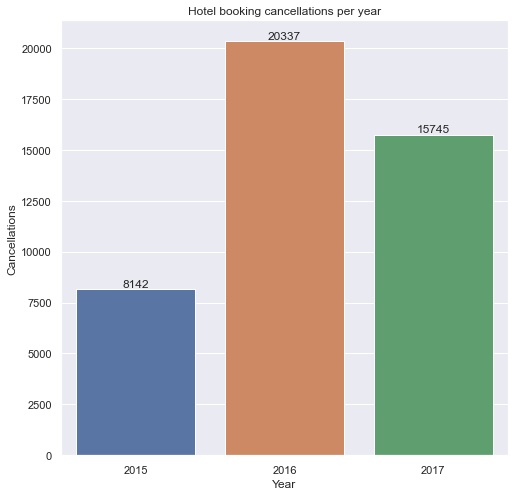

In [6]:
# Experiment 1: which year had the highest number of cancellations? And which one had the lowest?

ax = sns.barplot(x=hotel_cancellations["year_arrival_date"], 
            y=hotel_cancellations["cancellation"], 
            data=hotel_cancellations,
            estimator=sum,
            ci=None)

ax.bar_label(ax.containers[0])
ax.set_xlabel("Year")
ax.set_ylabel("Cancellations")
ax.set_title("Hotel booking cancellations per year")

Text(0.5, 1.0, 'Hotel arrivals per month')

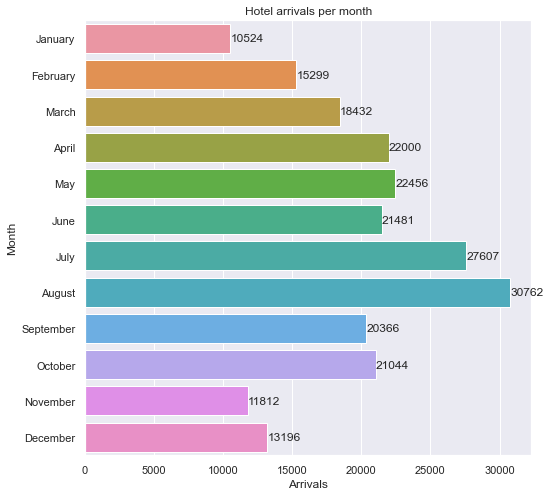

In [7]:
# Experiment 2: which month had the highest number of arrivals? And which one had the lowest?
# By arrivals we consider adults, children and babies as part of the same population

months = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]

num_arrivals = hotel_cancellations["num_adults"] +\
                 hotel_cancellations["num_children"] +\
                    hotel_cancellations["num_babies"]

ax = sns.barplot(x=num_arrivals, 
                 y=hotel_cancellations["month_arrival_date"], 
                 data=hotel_cancellations,
                 estimator=sum,
                 order=months,
                 ci=None)

ax.bar_label(ax.containers[0])
ax.set_xlabel("Arrivals")
ax.set_ylabel("Month")
ax.set_title("Hotel arrivals per month")

Text(0.5, 1.0, 'Average hotel booking price per month')

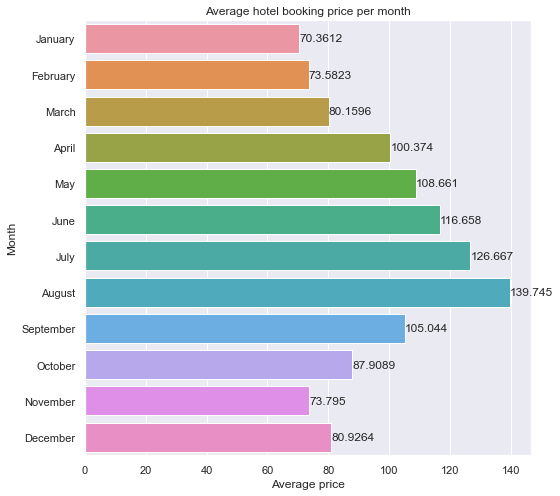

In [8]:
# Experiment 3: which month has the lowest average booking price?

ax = sns.barplot(x=hotel_cancellations["avg_price"], 
                 y=hotel_cancellations["month_arrival_date"], 
                 data=hotel_cancellations,
                 order=months,
                 ci=None)

ax.bar_label(ax.containers[0])
ax.set_xlabel("Average price")
ax.set_ylabel("Month")
ax.set_title("Average hotel booking price per month")

Text(0.5, 1.0, 'Hotel booking cancellations per month')

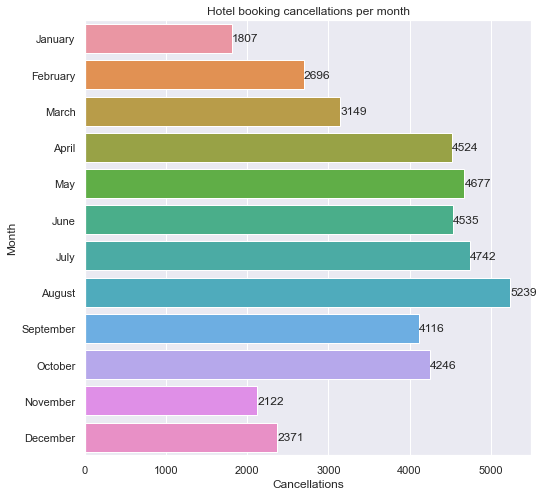

In [9]:
# Experiment 4: which month has the lowest number of cancellations?

ax = sns.barplot(x=hotel_cancellations["cancellation"], 
                 y=hotel_cancellations["month_arrival_date"], 
                 data=hotel_cancellations,
                 estimator=sum,
                 order=months,
                 ci=None)

ax.bar_label(ax.containers[0])
ax.set_xlabel("Cancellations")
ax.set_ylabel("Month")
ax.set_title("Hotel booking cancellations per month")

Text(0.5, 1.0, 'Do repeated guests have a lower number of previous cancellations?')

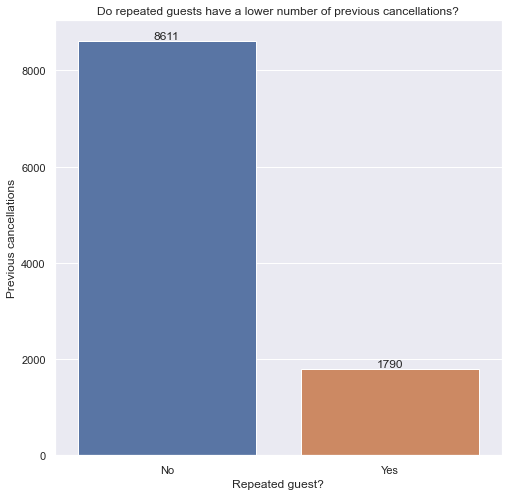

In [10]:
# Experiment 5: do repeated guests have a lower number of previous cancellations?

repeated_guests = hotel_cancellations["repeated_guest"].astype("str")
repeated_guests.replace({'0': "No", '1': "Yes"}, inplace=True)

ax = sns.barplot(x=repeated_guests, 
                 y=hotel_cancellations["num_previous_cancellations"], 
                 data=hotel_cancellations,
                 estimator=sum,
                 ci=None)

ax.bar_label(ax.containers[0])
ax.set_xlabel("Repeated guest?")
ax.set_ylabel("Previous cancellations")
ax.set_title("Do repeated guests have a lower number of previous cancellations?")

#### 2.3. Correlation tests
***
An effective (and simple) way to see if our any of our features is directly correlated with another is to create a correlation matrix, followed by a correlation plot (achieved through the use of ``seaborn`` and its pairplot). The problem with the correlation plot, in this task, is the number of features we have to examine; as such, we'll make use of a heatmap to plot our results in a more legible manner. 

Mathematically, and given we're referring to the whole population of our experiment, we can verify if a feature $X$ is correlated with feature $Y$ through the use of Pearson's population correlation coefficient, which is

<br>

$$corr(X, Y) = \frac{E[(X - \mu_X)(Y - \mu_Y)]}{\sigma_X \sigma_Y}$$

<br>

where $\sigma_x$ and $\sigma_y$ are the standard deviations of $X$ and $Y$, and $\mu_X$ and $\mu_Y$ are the means of $X$ and $Y$. 



In [11]:
# Showing a correlation matrix of the features in our dataframe

corr = hotel_cancellations.corr()

corr

,cancellation,days_between_booking_arrival,year_arrival_date,week_number_arrival_date,day_of_month_arrival_date,num_weekend_nights,num_workweek_nights,num_adults,num_children,num_babies,...,repeated_guest,num_previous_cancellations,num_previous_stays,changes_between_booking_arrival,id_travel_agency_booking,id_person_booking,customer_type,avg_price,required_car_parking_spaces,total_of_special_requests
cancellation,1.000000,0.293123,0.016660,0.008148,-0.006130,-0.001791,0.024765,0.060017,0.005048,-0.032491,...,-0.084793,0.110133,-0.057358,-0.144381,-0.083114,-0.020642,-0.135819,0.049277,-0.195498,-0.234658
days_between_booking_arrival,0.293123,1.000000,0.040142,0.126871,0.002268,0.085671,0.165799,0.119519,-0.037622,-0.020915,...,-0.124410,0.086042,-0.073548,0.000149,-0.069741,0.151464,0.162524,-0.065567,-0.116451,-0.095712
year_arrival_date,0.016660,0.040142,1.000000,-0.540561,-0.000221,0.021497,0.030883,0.029635,0.054624,-0.013192,...,0.010341,-0.119822,0.029218,0.030872,0.063457,0.259095,-0.199555,0.207913,-0.013684,0.108531
week_number_arrival_date,0.008148,0.126871,-0.540561,1.000000,0.066809,0.018208,0.015558,0.025909,0.005518,0.010395,...,-0.030131,0.035501,-0.020904,0.005508,-0.031201,-0.076760,0.063675,0.080316,0.001920,0.026149
day_of_month_arrival_date,-0.006130,0.002268,-0.000221,0.066809,1.000000,-0.016354,-0.028174,-0.001566,0.014544,-0.000230,...,-0.006145,-0.027011,-0.000300,0.010613,0.001487,0.044858,0.003114,0.030857,0.008683,0.003062
num_weekend_nights,-0.001791,0.085671,0.021497,0.018208,-0.016354,1.000000,0.498969,0.091871,0.045793,0.018483,...,-0.087239,-0.012775,-0.042715,0.063281,0.140739,0.066749,-0.042925,0.052624,-0.018554,0.072671
num_workweek_nights,0.024765,0.165799,0.030883,0.015558,-0.028174,0.498969,1.000000,0.092976,0.044203,0.020191,...,-0.097245,-0.013992,-0.048743,0.096209,0.182382,0.182211,-0.037803,0.069166,-0.024859,0.068192
num_adults,0.060017,0.119519,0.029635,0.025909,-0.001566,0.091871,0.092976,1.000000,0.030447,0.018146,...,-0.146426,-0.006738,-0.107983,-0.051673,-0.035594,0.207793,-0.093755,0.242301,0.014785,0.122884
num_children,0.005048,-0.037622,0.054624,0.005518,0.014544,0.045793,0.044203,0.030447,1.000000,0.024030,...,-0.032859,-0.024730,-0.021072,0.048949,0.041066,0.030931,-0.096125,0.339741,0.056253,0.081745
num_babies,-0.032491,-0.020915,-0.013192,0.010395,-0.000230,0.018483,0.020191,0.018146,0.024030,1.000000,...,-0.008943,-0.007501,-0.006550,0.083440,0.036184,0.019206,-0.022268,0.030870,0.037383,0.097889


<AxesSubplot:>

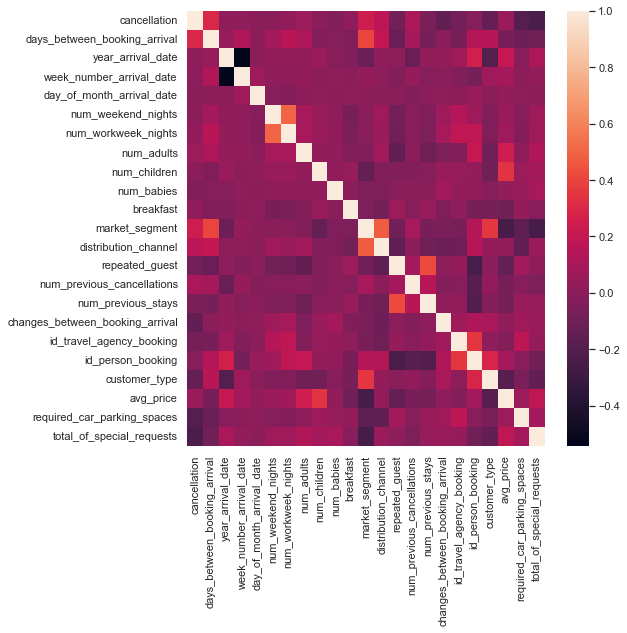

In [12]:
# Showing a correlation heatmap of the features in our dataframe

sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns)

The plot above indicates that the ``cancellation`` variable, the feature we're most interested in, has a positive (yet not very strong) correlation with the year of arrival, market segment and days between booking arrival. This indicates that these features do affect whether or not a guest will cancel their booking; however, further analysis, through hypothesis testing, is needed with other features in the dataset to verify whether these are truly the only variables that are correlated with the cancellation feature.

Additionally, other features are also correlated: for instance, the number of children has a positive correlation with the average booking price (as is expected). Although these results may or may not impact the cancellation rate, it's an interesting find nonetheless.

#### 2.4. Verifying our information and creating hypotheses
***
Based on the analysis we conducted, we now have some interesting information:

* 2016 was the year with the highest number of cancellations, whereas 2015 had the lowest. Thus, an unknown event in 2016 influenced these cancellations and, curiously, it did not affect the results obtained in 2017;

* August is the month with the highest number of arrivals and, yet, also the month where the average booking price is at its highest; it also possesses the highest number of cancellations. Thus, it can be assumed that an event in August offsets the elevated average booking price and draws in guests, but something causes many of them to cancel their trip as well;

* Repeated guests, as expected, have a much lower previous cancellation rate than other guests. Given the clarity of this information and the data supporting it, we'll consider it a factual statement.

As such, we have the following 3 hypotheses:

* $h1$: An event in 2016 caused a spike in the number of cancellations;
* $h2$: August has a benefit that offsets its higher average booking price and draws in guests;
* $h3$: August experiences an event that results in a higher number of booking cancellations than other months.

We could combine hypotheses #2 and #3 into a single statement, yet, for clarity and simplicity, we'll keep them separated.

#### 2.5. Hypothesis testing
***
Given our hypotheses $h1, h2$ and $h3$, we can define our null and alternate hypotheses as follows:

$h1_0$ = an event in 2016 resulted in a spike in the number of cancellations; <br>
$h1_a$ = no event in 2016 resulted in a spike in the number of cancellations; <br>

$h2_0$: August has a benefit that offsets its higher average booking price and draws in guests; <br>
$h2_a$: August has no benefit that offsets its higher average booking price and draws in guests; <br>

$h3_0$: August experiences an event that results in a higher number of booking cancellations than other months; <br>
$h3_a$: August does not experience an event that results in a higher number of booking cancellations than other months. <br>

To verify whether we should accept each null hypothesis or reject them in favor of their alternate counterparts, we can conduct several types of hypothesis tests. One of the simplest and most common tests, and the one that will be used here, is the t-test, also known as Student's t-test, which is given by the following formula

<br>

$$t = \frac{\overline{x} - \mu_0}{s / \sqrt{n}}$$

<br>

where $\overline{x}$ is the sample mean, $s$ is the sample standard deviation and $n$ is the sample size.

In [13]:
# Calculating Student's t-test for h1
# Here, we test the results of 2016 against 2015 and then against 2017

# Importing Student's t-test for independent variables from scipy.stats
from scipy.stats import ttest_ind

# Assembling our data
cancellations = hotel_cancellations["cancellation"] \
                    .groupby([hotel_cancellations["month_arrival_date"], hotel_cancellations["year_arrival_date"]]).sum()  

cancellations_2015 = []
cancellations_2016 = []
cancellations_2017 = []

# Performing a search on our dataframe (as a dict) for each year label
# Should it be found, we'll append the key's item to its respective list
for key, item in cancellations.iteritems():
    if key[1] == 2015:
        cancellations_2015.append(item)

    elif key[1] == 2016:
        cancellations_2016.append(item)

    else:
        cancellations_2017.append(item)


cancellations_2015 = np.array(cancellations_2015)
cancellations_2016 = np.array(cancellations_2016)
cancellations_2017 = np.array(cancellations_2017)

# Applying Student's t-test and retrieving the p-value
# If p < 0.05, we'll reject the null hypothesis
ttest_first, pvalue_first = ttest_ind(cancellations_2015, cancellations_2016)
ttest_second, pvalue_second = ttest_ind(cancellations_2016, cancellations_2017)

print(f"p-value for 2015 - 2016: {pvalue_first}")
print(f"p-value for 2016 - 2017: {pvalue_second}")

if pvalue_first < 0.05:
    print("Null hypothesis (2015 - 2016) is rejected")

else:
    print("Null hypothesis (2015 - 2016) is accepted")

if pvalue_second < 0.05:
    print("Null hypothesis (2016 - 2017) is rejected")

else:
    print("Null hypothesis (2016 - 2017) is accepted")

p-value for 2015 - 2016: 0.21582851727625943
p-value for 2016 - 2017: 0.26286128129250536
Null hypothesis (2015 - 2016) is accepted
Null hypothesis (2016 - 2017) is accepted


In [14]:
# Calculating Student's t-test for h2
# Here, we verify each month's average booking price and number of guest arrivals

# Assembling our data
monthly_data = hotel_cancellations["avg_price"] \
                    .groupby([hotel_cancellations["month_arrival_date"], num_arrivals]).mean()  

august_data = np.array(monthly_data["August"])
other_months = np.array(monthly_data.drop("August"))

# Applying Student's t-test and retrieving the p-value
# If p < 0.05, we'll reject the null hypothesis
ttest, pvalue = ttest_ind(august_data, other_months)

print(f"p-value: {pvalue}")

if pvalue < 0.05:
    print("Null hypothesis is rejected")

else:
    print("Null hypothesis is accepted")


p-value: 0.08328657136969336
Null hypothesis is accepted


In [15]:
# Calculating Student's t-test for h3
# Here, we verify each month's number of cancellations

# Assembling our data
monthly_data = hotel_cancellations["cancellation"] \
                    .groupby([hotel_cancellations["month_arrival_date"], num_arrivals]).sum()  

august_data = np.array(monthly_data["August"])
other_months = np.array(monthly_data.drop("August"))

# Applying Student's t-test and retrieving the p-value
# If p < 0.05, we'll reject the null hypothesis
ttest, pvalue = ttest_ind(august_data, other_months)

print(f"p-value: {pvalue}")

if pvalue < 0.05:
    print("Null hypothesis is rejected")

else:
    print("Null hypothesis is accepted")


p-value: 0.38592784920957746
Null hypothesis is accepted


#### 2.6. Reviewing our results
***
The results we obtained seem to confirm our earlier assumptions, which are:

* An event truly did cause a spike in the amount of booking cancellations in 2016;
* August, despite possessing the costliest average booking price, still manages to draw in guests through some sort of benefit;
* August still manages to have a higher booking cancellation rate than other months, despite its apparent popularity.

Now, however, the reaction we have is *why* were our assumptions correct? What did happen in 2016 to cause such an increase in booking cancellations, and what is happening with August? Although looking for these answers is not an objective here, we can still speculate:

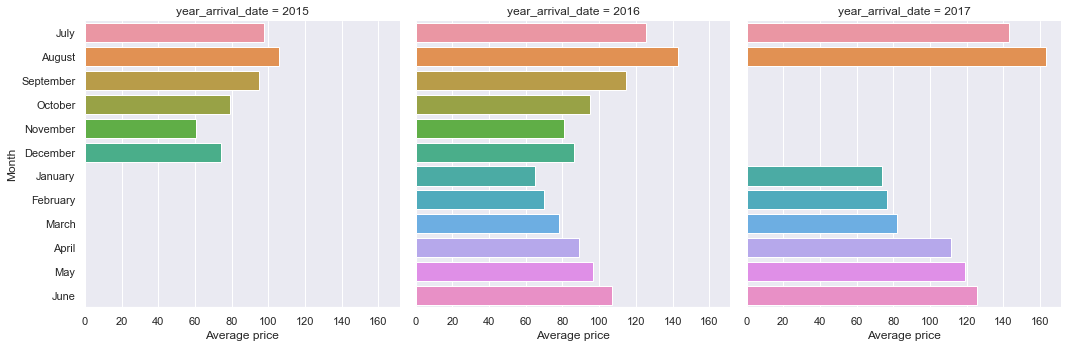

In [16]:
g = sns.catplot(data=hotel_cancellations,
                 kind="bar",
                 x="avg_price",
                 y="month_arrival_date",
                 col="year_arrival_date",
                 ci=None,
                 row_order="month_arrival_date",
                 height=5,
                 aspect=1,
                 orient="h")

g.despine(left=True)
g.set_axis_labels("Average price", "Month")

For the first question, if we take a look at the average booking price in 2016, we'll see that the prices are higher than in 2015, which might have prompted a backlash by guests. By 2017, even though the average price is even higher, it is possible that hotel guests haven't been taken aback by the price change as suddenly as in 2016. 

However, there is one crucial detail here: there are missing values for 2015 and 2017, which could imply that our hypotheses aren't as precise as they seem to be. Considering the trend, however, it's likely that they wouldn't be much different from what we've got, as, even though there are missing values, it's *extremely* unlikely that they'd have deviated from the data we already have.

As for the second question, it is actually rather simple: August is a very popular month in the Northern hemisphere, despite the fact that it's usually dominated by winter; it's one of the busiest travelling months, and, in many countries, it is frequently a holiday month<a href="#"><sup>1</sup></a>.

***

<small><a href="#"><sup>1</sup></a>https://bikehike.org/why-do-people-travel-so-much-in-august</small>

### 3. Selecting appropriate features for the classification model
***
Based on prior analysis, we've found several interesting things about this dataset, some of which are:

* The cancellation feature is correlated with the market segment, year of arrival and days between booking arrival;
* Specific months are a factor in whether a guest will cancel their booking or not;
* Repeated guests are way less likely to cancel their booking;
* The average booking price has significance in booking cancellations;
* 2016, the year where there was a significant increase in the average booking price, had the highest amount of booking cancellations.

These results show us that basing our upcoming training data on a temporal basis (e.g., prioritizing data from 2016 or specific months) is likely going to result in a biased model. Coupled with the lack of data from 2015 and 2017, it's clear that we'll need to sample from all different periods to obtain an adequate dataset for our classification model. As such, we'll focus on the following features for our training data:

* ``year_arrival_date``;
* ``month_arrival_date``;
* ``days_between_booking_arrival``;
* ``avg_price``;
* ``market_segment``;
* ``repeated_guest``.

#### 3.1. Preparing our data for training
***
Our features of interest are not entirely numeric, which means we will need to convert some of them into an appropriate format. Additionally, missing values are still a problem (which we detected earlier when comparing the average booking price by year); we'll need to deal with these null values, which is a task in itself, as we do not truly know what could have been there and, thus, we can only *infer*. A reasonable approach is to make use of pandas' ``mean()`` method, which fills missing values by inserting the column's mean value.

In [17]:
# Performing a deep copy of our original dataframe with only the data we want
training_data = hotel_cancellations[["year_arrival_date", 
                                    "month_arrival_date", 
                                    "days_between_booking_arrival",
                                    "avg_price", 
                                    "market_segment",
                                    "repeated_guest",
                                    "cancellation"]].copy()

# Replacing our null numeric data by mean values
training_data.fillna(training_data.mean(numeric_only=True))

# Converting our categorical features (month_arrival_date) to numeric
training_data = pd.get_dummies(training_data, columns=["month_arrival_date"])

training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   year_arrival_date             119390 non-null  int64  
 1   days_between_booking_arrival  119390 non-null  int64  
 2   avg_price                     119390 non-null  float64
 3   market_segment                119390 non-null  int64  
 4   repeated_guest                119390 non-null  int64  
 5   cancellation                  119390 non-null  int64  
 6   month_arrival_date_April      119390 non-null  uint8  
 7   month_arrival_date_August     119390 non-null  uint8  
 8   month_arrival_date_December   119390 non-null  uint8  
 9   month_arrival_date_February   119390 non-null  uint8  
 10  month_arrival_date_January    119390 non-null  uint8  
 11  month_arrival_date_July       119390 non-null  uint8  
 12  month_arrival_date_June       119390 non-nul

### 4. Applying machine learning to the task
***
Given this is a classification task, and the data we have is well structured, the use of a supervised classification algorithm becomes a natural choice for us. Our objective now is to predict the cancellation feature based on what we have learned about our dataset so far.

#### 4.1. Choosing an appropriate model
***
Simply looking at the data we have and picking a classification model is a nearly impossible task: some models work better on some datasets than others. As such, the sensible option is to choose a selection of $n$ different models and train them on the data we have, then pick the best among them to be our model of choice. Popular classification models include, but are not limited to:

* k-Nearest neighbors;
* Logistic regression; 
* Ridge linear classifier;
* Decision trees;
* Random forests;
* Gradient-boosted trees;
* Naive Bayes (and its variants).

Neural networks are also proficient in this task and would very likely suit well here. However, for the sake of simplicity, portability and overall *training speed*, we'll make use of the models described above and will choose the best among them for this task.

In [45]:
# Importing all required libraries for model selection
# We also import the tools we need for training and evaluation

# Uncomment this line to install scikit-learn and LightGBM
#%pip install sklearn lightgbm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, f1_score

In [19]:
# Splitting our data into training and testing datasets
X = training_data.drop("cancellation", axis=1)
y = training_data.pop("cancellation")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

In [20]:
# Creating and fitting our models without cross-validation

# Our models are basic and have no sort of hyperparameter tuning as of now
# This is intended to make our tests as unbiased as possible
models = [KNeighborsClassifier(),
          LogisticRegression(max_iter=1000),
          RidgeClassifier(),
          RandomForestClassifier(),
          DecisionTreeClassifier(),
          MultinomialNB(),
          GaussianNB(),
          LGBMClassifier()]

fitted_models = []

for model in models:
    fitted_models.append(model.fit(X_train, y_train))

In [21]:
# Creating a dataframe out of our models to check how accurate they are on the test set

train_accuracy = []
test_accuracy = []
train_precision = []
test_precision = []
train_f1 = []
test_f1 = []

for model in fitted_models:
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    train_accuracy.append(accuracy_score(y_train, train_pred))
    test_accuracy.append(accuracy_score(y_test, test_pred))
    train_precision.append(precision_score(y_train, train_pred))
    test_precision.append(precision_score(y_test, test_pred))
    train_f1.append(f1_score(y_train, train_pred))
    test_f1.append(f1_score(y_test, test_pred))

results_df = pd.DataFrame({
    "model": [type(model).__name__ for model in models],
    "train_accuracy": train_accuracy,
    "test_accuracy": test_accuracy,
    "train_precision": train_precision,
    "test_precision": test_precision,
    "train_f1_score": train_f1,
    "test_f1_score": test_f1
    }
)

In [22]:
# Verifying the performance of our models

results_df

,model,train_accuracy,test_accuracy,train_precision,test_precision,train_f1_score,test_f1_score
0,KNeighborsClassifier,0.832555,0.762082,0.807480,0.705040,0.760020,0.663866
1,LogisticRegression,0.680030,0.677904,0.622769,0.628355,0.439237,0.443689
2,RidgeClassifier,0.686929,0.684019,0.640623,0.643252,0.450351,0.454328
3,RandomForestClassifier,0.965387,0.801282,0.967812,0.758400,0.952400,0.722011
4,DecisionTreeClassifier,0.965428,0.780258,0.981829,0.712887,0.951770,0.702332
5,MultinomialNB,0.639448,0.641888,0.511926,0.522032,0.512383,0.521301
6,GaussianNB,0.586209,0.586900,0.455968,0.461851,0.526399,0.530330
7,LGBMClassifier,0.769097,0.763004,0.827668,0.820989,0.602358,0.597539


#### 4.2. Improving our models with cross-validation
***
Some of our models, such as the random forest classifier and gradient-boosted trees, managed to obtain over 75% accuracy in our dataset. Although this is seems good, it should be noted that the test results are not as impressive and, in some cases, are downright terrible. This is when we rectify this: by using cross-validation, which will frequently shift between which values are used for training and testing, the goal is to ensure that the models will be able to learn more effectively than with the previously used ``train_test_split``.

In [55]:
# Fitting our models through the use of cross-validation
# We also create a dataframe to see how accurate our modelsare on the test set

accuracy = []
precision = []
f1 = []

# For each model, we extract the mean of the stratified k-fold cross-validated scores
for model in models:
    acc = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=15, shuffle=True), scoring="accuracy")
    prec = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=15, shuffle=True), scoring="precision")
    f1_s = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=15, shuffle=True), scoring="f1")

    accuracy.append(acc.mean())
    precision.append(prec.mean())
    f1.append(f1_s.mean())

results_df = pd.DataFrame({
    "model": [type(model).__name__ for model in models],
    "accuracy": accuracy,
    "precision": precision,
    "f1_score": f1
    }
)

In [56]:
# Verifying the performance of our models

results_df

,model,accuracy,precision,f1_score
0,KNeighborsClassifier,0.763891,0.703437,0.664150
1,LogisticRegression,0.684815,0.634890,0.455505
2,RidgeClassifier,0.686163,0.640347,0.451281
3,RandomForestClassifier,0.801751,0.755228,0.721193
4,DecisionTreeClassifier,0.783240,0.712613,0.704147
5,MultinomialNB,0.640079,0.514312,0.514043
6,GaussianNB,0.585192,0.456901,0.528265
7,LGBMClassifier,0.763112,0.810807,0.592588


Based on our metrics, the best models for this task are a random forest classifier, a decision tree classifier, a k-neighbors classifier and a gradient-boosted tree, respectively. Their overall accuracy, precision and f1 score were higher than those of any other model; notably, the results we got are almost equivalent to those we had previously obtained, which is an indication of overfitting.

#### 5. Conclusion
***
By doing a thorough analysis of the hotel cancellations dataset, we were able to identify correlated features, create and validate hypotheses, and choose an appropriate classification model out of several candidates. The use of hyperparameter tuning was also shown here, where the data we had was split, and then fit, to each model through the use of stratified 15-fold cross-validation; the results showed us that the models were overfitting in some cases, thus bringing us a clearer vision of our results.

As an addendum, it should be noted that the results acquired here would likely be overshadowed by those obtained on a *deeper* analysis, such as those making use of other statistical tests (such as ANOVA), confidence intervals and additional model hyperparameter tuning techniques.